# Modeling and Simulation in Python

Chapter 25

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Teapots and Turntables

Tables in Chinese restaurants often have a rotating tray or turntable that makes it easy for customers to share dishes.  These turntables are supported by low-friction bearings that allow them to turn easily and glide.  However, they can be heavy, especially when they are loaded with food, so they have a high moment of inertia.

Suppose I am sitting at a table with a pot of tea on the turntable directly in front of me, and the person sitting directly opposite asks me to pass the tea.  I push on the edge of the turntable with 1 Newton of force until it has turned 0.5 radians, then let go.  The turntable glides until it comes to a stop 1.5 radians from the starting position.  How much force should I apply for a second push so the teapot glides to a stop directly opposite me?

The following figure shows the scenario, where `F` is the force I apply to the turntable at the perimeter, perpendicular to the moment arm, `r`, and `tau` is the resulting torque.  The blue circle near the bottom is the teapot.

![](diagrams/teapot.png)

We'll answer this question in these steps:

1.  We'll use the results from the first push to estimate the coefficient of friction for the turntable.

2.  We'll use that coefficient of friction to estimate the force needed to rotate the turntable through the remaining angle.

Our simulation will use the following parameters:

1.  The radius of the turntable is 0.5 meters, and its weight is 7 kg.

2.  The teapot weights 0.3 kg, and it sits 0.4 meters from the center of the turntable.

As usual, I'll get units from Pint.

In [2]:
radian = UNITS.radian
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
N = UNITS.newton

<Unit('newton')>

And store the parameters in a `Params` object.

In [3]:
params = Params(radius_disk=0.5*m,
                mass_disk=7*kg,
                radius_pot=0.4*m,
                mass_pot=0.3*kg,
                force=1*N,
                torque_friction=0.2*N*m,
                theta_end=0.5*radian)

,values
radius_disk,0.5 meter
mass_disk,7 kilogram
radius_pot,0.4 meter
mass_pot,0.3 kilogram
force,1 newton
torque_friction,0.2 meter * newton
theta_end,0.5 radian


`make_system` creates the initial state, `init`, and computes the total moment of inertia for the turntable and the teapot.

In [4]:
def make_system(params):
    """Make a system object.
    
    params: Params object
    
    returns: System object
    """
    unpack(params)
    
    init = State(theta=0, omega=0)
    
    I_disk = mass_disk * radius_disk**2 / 2
    I_pot = mass_pot * radius_pot**2
    
    return System(params, init=init, t_end=20*s,
                  I=I_disk+I_pot)

Here's the `System` object we'll use for the first phase of the simulation, while I am pushing the turntable.

In [5]:
system1 = make_system(params)

,values
radius_disk,0.5 meter
mass_disk,7 kilogram
radius_pot,0.4 meter
mass_pot,0.3 kilogram
force,1 newton
torque_friction,0.2 meter * newton
theta_end,0.5 radian
init,theta 0 omega 0 dtype: int64
t_end,20 second
I,0.923 kilogram * meter ** 2


### Simulation

When I stop pushing on the turntable, the angular acceleration changes abruptly.  We could implement the slope function with an `if` statement that checks the value of `theta` and sets `force` accordingly.  And for a coarse model like this one, that might be fine.  But we will get more accurate results if we simulate the system in two phases:

1.  During the first phase, force is constant, and we run until `theta` is 0.5 radians.

2.  During the second phase, force is 0, and we run until `omega` is 0.

Then we can combine the results of the two phases into a single `TimeFrame`.

Here's the slope function we'll use:

In [6]:
def slope_func(state, t, system):
    """Computes the derivatives of the state variables.
    
    state: State object
    t: time
    system: System object 
    
    returns: sequence of derivatives
    """
    theta, omega = state
    unpack(system)
    
    torque = radius_disk * force - torque_friction
    alpha = torque / I
    
    return omega, alpha 

As always, we'll test the slope function before running the simulation.

In [7]:
slope_func(system1.init, 0*s, system1)

(0, <Quantity(0.32502708559046584, 'newton / kilogram / meter')>)

Here's an event function that stops the simulation when `theta` reaches `theta_end`.

In [8]:
def event_func1(state, t, system):
    """Stops when theta reaches theta_end.
    
    state: State object
    t: time
    system: System object 
    
    returns: difference from target
    """
    theta, omega = state
    unpack(system)
    return theta - theta_end 

Now we can run the first phase.

In [9]:
results1, details1 = run_ode_solver(system1, slope_func,
                                    events=event_func1, max_step=0.1*s)
details1

,values
sol,None
t_events,[[1.7540429489230491]]
nfev,128
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


And look at the results.

In [10]:
results1.tail()

,theta,omega
1.411100,0.323597,0.458646
1.511100,0.371087,0.491148
1.611100,0.421827,0.523651
1.711100,0.475817,0.556154
1.754043,0.500000,0.570111


### Phase 2

Before we run the second phase, we have to extract the final time and state of the first phase.

In [11]:
t_0 = get_last_label(results1) * s

<Quantity(1.7540429489230491, 'second')>

And make an initial `State` object for Phase 2.

In [12]:
theta, omega = get_last_value(results1)
init2 = State(theta=theta*radian, omega=omega*radian/s)

,values
theta,0.49999999999999994 radian
omega,0.570111467688965 radian / second


And a new `System` object with `force=0`.

In [13]:
system2 = System(system1, t_0=t_0, init=init2, force=0)

,values
radius_disk,0.5 meter
mass_disk,7 kilogram
radius_pot,0.4 meter
mass_pot,0.3 kilogram
force,0
torque_friction,0.2 meter * newton
theta_end,0.5 radian
init,theta 0.49999999999999994 radian ome...
t_end,20 second
I,0.923 kilogram * meter ** 2


Here's an event function that stops when angular velocity is 0.

In [14]:
def event_func2(state, t, system):
    """Stops when omega is 0.
    
    state: State object
    t: time
    system: System object 
    
    returns: omega
    """
    theta, omega = state
    return omega

Now we can run the second phase.

In [15]:
results2, details2 = run_ode_solver(system2, slope_func,
                         events=event_func2, max_step=0.1*s)
details2

,values
sol,None
t_events,[[4.385107372307622]]
nfev,164
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


And check the results.

In [16]:
results2.tail()

,theta,omega
4.054043,1.238125,0.071737
4.154043,1.244216,0.050068
4.254043,1.248139,0.028400
4.354043,1.249895,0.006731
4.385107,1.250000,0.000000


Pandas provides `combine_first`, which combines `results1` and `results2`.

In [17]:
results = results1.combine_first(results2)
results.tail()

,theta,omega
4.054043,1.238125,0.071737
4.154043,1.244216,0.050068
4.254043,1.248139,0.028400
4.354043,1.249895,0.006731
4.385107,1.250000,0.000000


Now we can plot `theta` for both phases.

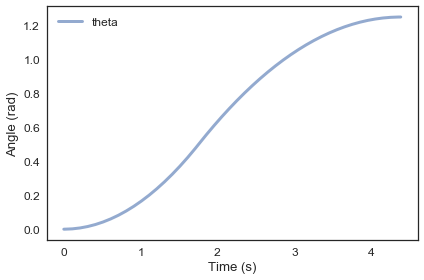

In [18]:
def plot_theta(results):
    plot(results.theta, label='theta')
    decorate(xlabel='Time (s)',
             ylabel='Angle (rad)')
    
plot_theta(results)

And `omega`.

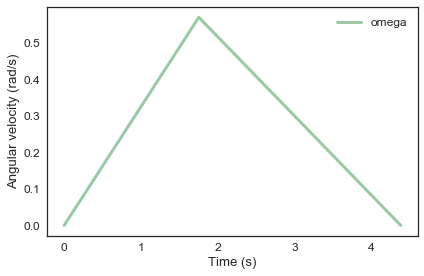

In [19]:
def plot_omega(results):
    plot(results.omega, label='omega', color='C1')
    decorate(xlabel='Time (s)',
             ylabel='Angular velocity (rad/s)')
    
plot_omega(results)

Saving figure to file figs/chap25-fig01.pdf


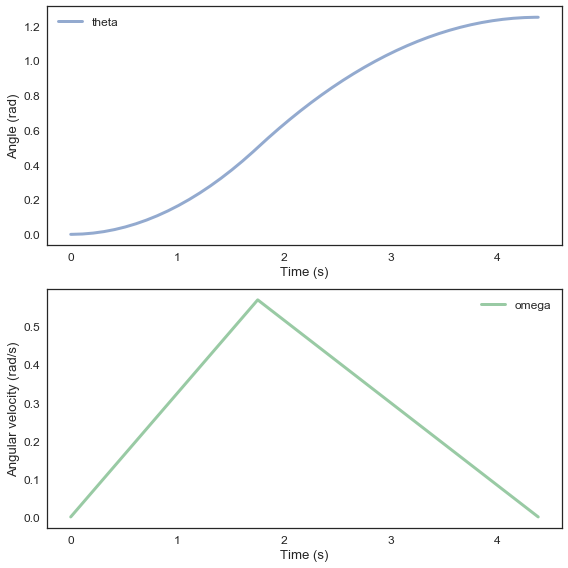

In [20]:
subplot(2, 1, 1)
plot_theta(results)
subplot(2, 1, 2)
plot_omega(results)
savefig('figs/chap25-fig01.pdf')

### Estimating friction

Let's take the code from the previous section and wrap it in a function.

In [21]:
def run_two_phases(force, torque_friction, params):
    """Run both phases.
    
    force: force applied to the turntable
    torque_friction: friction due to torque
    params: Params object
    
    returns: TimeFrame of simulation results
    """
    # put the specified parameters into the Params object
    params = Params(params, force=force, torque_friction=torque_friction)

    # run phase 1
    system1 = make_system(params)
    results1, details1 = run_ode_solver(system1, slope_func, 
                             events=event_func1, max_step=0.1*s)

    # get the final state from phase 1
    t_0 = get_last_label(results1) * s
    theta, omega = get_last_value(results1)
    init2 = State(theta=theta, omega=omega)
    
    # run phase 2
    system2 = System(system1, t_0=t_0, init=init2, force=0)
    results2, details2 = run_ode_solver(system2, slope_func, 
                             events=event_func2, max_step=0.1*s)
    
    # combine and return the results
    results = results1.combine_first(results2)
    return results

Let's test it with the same parameters.

In [22]:
force = 1*N
torque_friction = 0.2*N*m
results = run_two_phases(force, torque_friction, params)
results.tail()

,theta,omega
4.054043,1.238125,0.071737
4.154043,1.244216,0.050068
4.254043,1.248139,0.028400
4.354043,1.249895,0.006731
4.385107,1.250000,0.000000


And check the results.

In [23]:
theta_final = get_last_value(results.theta)

1.2499999999999993

To estimate the coefficient of friction, we'll use `fsolve`, which doesn't always work well with units.

So for the rest of this example, we'll run without units.  Here's a version of the `Params` object with no units.

In [24]:
params_nodim = remove_units(params)

<class 'modsim.Params'>


,values
radius_disk,0.5
mass_disk,7
radius_pot,0.4
mass_pot,0.3
force,1
torque_friction,0.2
theta_end,0.5


Here's the error function we'll use with `fsolve`.  It takes a hypothetical value for `torque_friction` and returns the difference between `theta_final` and the observed result of the first push.

In [25]:
def error_func1(torque_friction, params):
    """Error function for fsolve.
    
    torque_friction: hypothetical value
    params: Params object
    
    returns: offset from target value
    """
    force = 1
    results = run_two_phases(force, torque_friction, params)
    theta_final = get_last_value(results.theta)
    print(torque_friction, theta_final)
    return theta_final - 1.5

Testing the error function.

In [26]:
guess = 0.2
error_func1(guess, params_nodim)

0.2 1.2499999999999993


-0.25000000000000067

And running `fsolve`.

In [27]:
res = fsolve(error_func1, guess, params_nodim)

0.2 1.2499999999999993
[0.2] 1.2499999999999993
[0.2] 1.2499999999999993
[0.2] 1.2499999999999993
[0.2] 1.2499999813735485
[0.16] 1.5625000139706928
[0.168] 1.4880952355608708
[0.16672] 1.4995201533449916
[0.16666624] 1.5000038400123006
[0.16666667] 1.499999998771198
[0.16666667] 1.499999999999997


array([0.16666667])

The result is an array, so we'll extract the first (and only) element.

In [28]:
torque_friction = res[0]

0.1666666666666669

And do a test run with the estimated value.

In [29]:
force = 1
results = run_two_phases(force, torque_friction, params_nodim)
theta_final = get_last_value(results.theta)

1.499999999999997

Looks good.

### Exercises

Now finish off the example by estimating the force that delivers the teapot to the desired position.

Write an error function that takes `force` and `params` and returns the offset from the desired angle.

In [30]:
def error_func2(force, params):
    """Error function for fsovle.
    
    force: hypothetical value
    params: Params object
    
    returns: offset from target value
    """
    results = run_two_phases(force, torque_friction, params)
    theta_final = get_last_value(results.theta)
    print(force, theta_final)
    remaining_angle = np.pi - 1.5
    
    return theta_final - remaining_angle

Test the error function with `force=1`

In [31]:
guess = 1
error_func2(guess, params_nodim)

1 1.499999999999997


-0.14159265358979622

And run `fsolve` to find the desired force.

In [32]:
res = fsolve(error_func2, guess, params_nodim)

1 1.499999999999997
[1] 1.499999999999997
[1.] 1.499999999999997
[1.] 1.499999999999997
[1.00000001] 1.500000022351739
[1.0943951] 1.6415926521835056
[1.0943951] 1.641592653589793


array([1.0943951])

In [33]:
force = res[0]
results = run_two_phases(force, torque_friction, params_nodim)
theta_final = get_last_value(results.theta)

1.641592653589793

**Exercise:** Now suppose my friend pours 0.1 kg of tea and puts the teapot back on the turntable at distance 0.3 meters from the center.  If I ask for the tea back, how much force should they apply, over an arc of 0.5 radians, to make the teapot glide to a stop back in front of me?  You can assume that torque due to friction is proportional to the total mass of the teapot and the turntable.

In [34]:
params_nodim

,values
radius_disk,0.5
mass_disk,7
radius_pot,0.4
mass_pot,0.3
force,1
torque_friction,0.2
theta_end,0.5


In [35]:
mass_before = params_nodim.mass_pot + params_nodim.mass_disk

7.3

In [36]:
params_nodim2 = Params(params_nodim, mass_pot = 0.2, radius_pot = 0.33)

,values
radius_disk,0.5
mass_disk,7
radius_pot,0.33
mass_pot,0.2
force,1
torque_friction,0.2
theta_end,0.5


In [37]:
mass_after = params_nodim2.mass_pot + params_nodim2.mass_disk

7.2

In [38]:
torque_friction

0.1666666666666669

In [39]:
torque_friction2 =torque_friction * mass_after / mass_before

0.16438356164383586

In [40]:
guess = 2
results = run_two_phases(guess, torque_friction2, params_nodim2)
results.tail()

,theta,omega
5.929863,3.028971,6.822138e-02
6.029863,3.034877,4.989095e-02
6.129863,3.038950,3.156053e-02
6.229863,3.041189,1.323011e-02
6.302039,3.041667,6.245005e-17


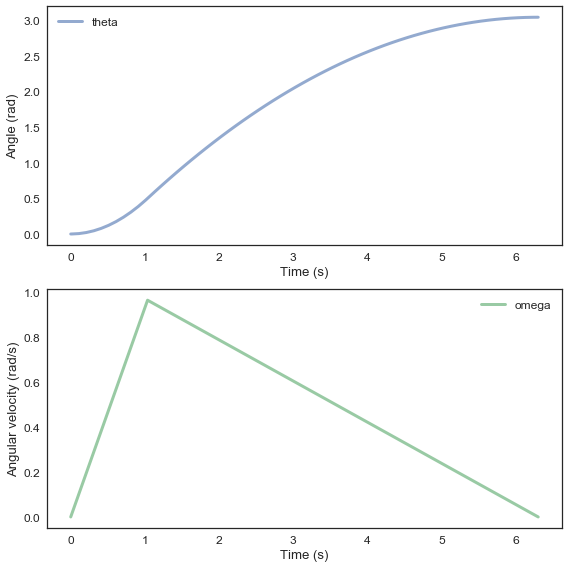

In [41]:
subplot(2, 1, 1)
plot_theta(results)
subplot(2, 1, 2)
plot_omega(results)

In [42]:
def error_func3(force, params):
    """Error function for fsovle.
    
    force: hypothetical value
    params: Params object
    
    returns: offset from target value
    """
    results = run_two_phases(force, torque_friction, params)
    theta_final = get_last_value(results.theta)
    print(force, theta_final)
    remaining_angle = np.pi
    
    return theta_final - remaining_angle

In [43]:
res = fsolve(error_func3, guess, params_nodim2)

2 3.041666666666666
[2] 3.041666666666666
[2.] 3.041666666666666
[2.] 3.041666666666666
[2.00000003] 3.041666711991032
[2.06570476] 3.141592651958217
[2.06570476] 3.141592653589796


array([2.06570476])


**Exercise:** Run these simulations with different values for the weight and size of the turntable, or weight and location of the teapot.  What effect do they have on the results?

If you do some analysis, you might find that you can answer the original question without doing any simulation.